# Vanilla models test

- Artificial Neural Networks
- Decision Tree Classifier
- Random Forest
- Gradient Boosting

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17850940225373727997
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9085094306211961836
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Dataset loading

In [10]:
train_dir = 'data/real_vs_fake/real-vs-fake/train'
valid_dir = 'data/real_vs_fake/real-vs-fake/valid'
test_dir =  'data/real_vs_fake/real-vs-fake/test'

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
batch_size = 32
image_height = 256
image_width = 256

# Create the generators for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'      # Set the class mode to 'binary' since we have two classes
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


fake images have label 0 and real images have label 1

In [37]:
classes = list(train_generator.class_indices.keys())

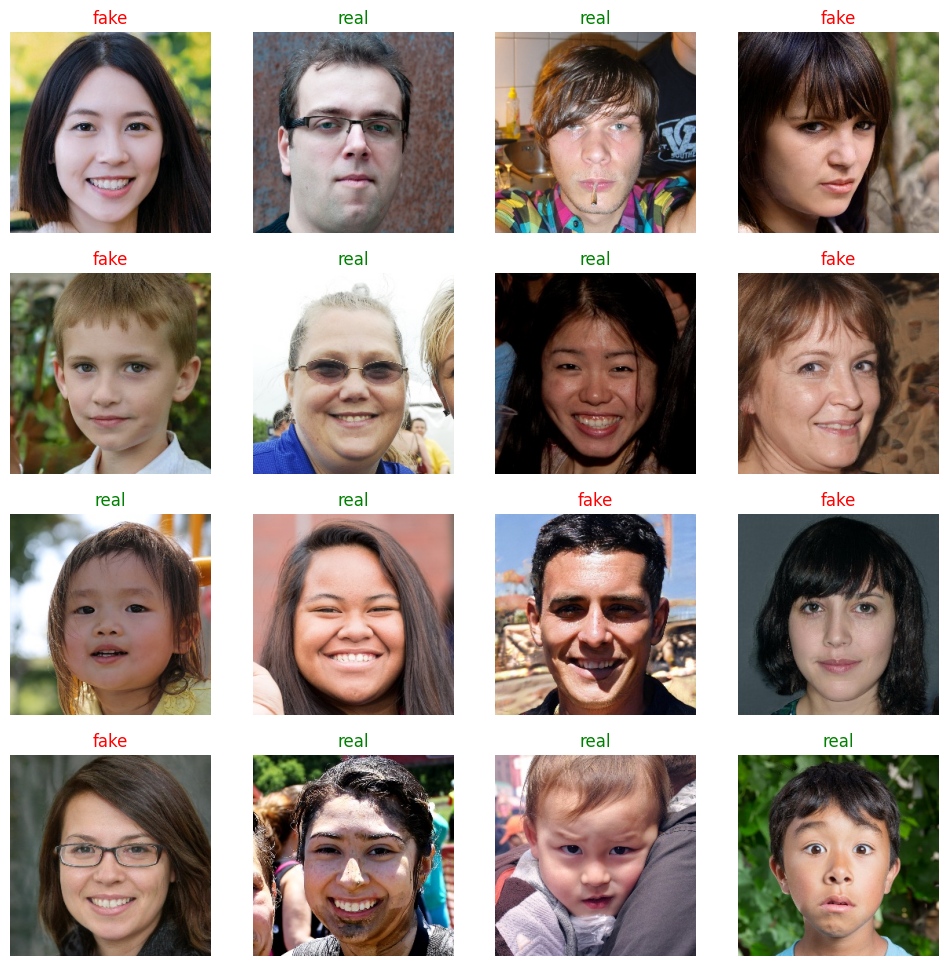

In [43]:
# Checking some images
images, labels = train_generator.next()

# Display the images along with their labels
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')

    if int(labels[i]) == 0:
        title_color = 'red'
    else:
        title_color = 'green'

    ax.set_title(classes[int(labels[i])], color=title_color)

plt.show()